## TEC-EMT signature analysis and marker plotting

In [1]:
import sys 
import os
from datetime import datetime

import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
#import scvi
import hdf5plugin

import matplotlib.pyplot as plt
import seaborn as sns

# Add repo path to sys path (allows to access scripts and metadata from repo)
repo_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/TEC_compartment'
sys.path.insert(1, repo_path) 
sys.path.insert(2, '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts')


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

In [3]:
# Define plot and path dirs
plot_path = os.path.join(repo_path, 'plots')
data_path = os.path.join(repo_path, 'data')
results_path = os.path.join(repo_path, 'results')
model_path = os.path.join(repo_path, 'models')
general_data_path = '/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/data'

In [4]:
# Formatting
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
#plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

# Import custom scripts
from utils import get_latest_version,update_obs,freq_by_donor
from anno_levels import get_ct_levels, get_ct_palette, age_group_levels, age_group_palette
from plotting.utils import plot_grouped_boxplot, calc_figsize

In [5]:
sc.settings.set_figure_params(dpi = 80, color_map = 'RdPu')
plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

## Load adata

In [6]:
object_version = 'v5_2025-04-03'
adata = ad.read_h5ad(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_{object_version}.zarr')

In [7]:
# Add final annotations to adata and remove non-annotated cells
ct_anno = pd.read_csv(f'{general_data_path}/objects/rna/thyAgeing_all_scvi_v4_2025-02-04_curatedAnno_v10.csv', index_col = 0)

for c in ct_anno.columns:
    if c in adata.obs.columns:
        adata.obs.drop(c, axis = 1, inplace = True)
adata.obs = adata.obs.join(ct_anno)

adata = adata[~adata.obs['taa_l5'].isnull(),].copy()

In [8]:
adata.obs['study'].value_counts()

study
Thymus_ageing        271867
Yayon2024            245902
Park2020             218749
Li2024                87981
Heimli2024            77636
Notarangelo2024       59325
TabulaSapiens2022     34353
Bautista2021          28238
Campinoti2020          1247
Name: count, dtype: int64

In [9]:
adata.obs.loc[adata.obs['study']=='Notarangelo2024', 'study'] = 'Thymus_ageing'

In [10]:
adata.obs[['study', 'donor']].drop_duplicates().reset_index(drop = True).groupby('study').size()

/tmp/ipykernel_802/4287984612.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs[['study', 'donor']].drop_duplicates().reset_index(drop = True).groupby('study').size()


study
Bautista2021          3
Campinoti2020         1
Heimli2024            5
Li2024               12
Notarangelo2024       0
Park2020              9
TabulaSapiens2022     2
Thymus_ageing        22
Yayon2024             9
dtype: int64

In [11]:
HLM_EMT = ['ABI3BP', 'ACTA2', 'ADAM12', 'ANPEP', 'APLP1', 'AREG', 'BASP1', 'BDNF', 'BGN', 'BMP1', 'CADM1',
           'CALD1', 'CALU', 'CAP2', 'CAPG', 'CCN1', 'CCN2', 'CD44', 'CD59', 'CDH11', 'CDH2', 'CDH6', 'COL11A1',
           'COL12A1', 'COL16A1', 'COL1A1', 'COL1A2', 'COL3A1', 'COL4A1', 'COL4A2', 'COL5A1', 'COL5A2', 'COL5A3',
           'COL6A2', 'COL6A3', 'COL7A1', 'COL8A2', 'COLGALT1', 'COMP', 'COPA', 'CRLF1', 'CTHRC1', 'CXCL1', 
           'CXCL12', 'CXCL6', 'CXCL8', 'DAB2', 'DCN', 'DKK1', 'DPYSL3', 'DST', 'ECM1', 'ECM2', 'EDIL3',
           'EFEMP2', 'ELN', 'EMP3', 'ENO2', 'FAP', 'FAS', 'FBLN1', 'FBLN2', 'FBLN5', 'FBN1', 'FBN2', 'FERMT2',
           'FGF2', 'FLNA', 'FMOD', 'FN1', 'FOXC2', 'FSTL1', 'FSTL3', 'FUCA1', 'FZD8', 'GADD45A', 'GADD45B', 
           'GAS1', 'GEM', 'GJA1', 'GLIPR1', 'GPC1', 'GPX7', 'GREM1', 'HTRA1', 'ID2', 'IGFBP2', 'IGFBP3', 
           'IGFBP4', 'IL15', 'IL32', 'IL6', 'INHBA', 'ITGA2', 'ITGA5', 'ITGAV', 'ITGB1', 'ITGB3', 'ITGB5', 
           'JUN', 'LAMA1', 'LAMA2', 'LAMA3', 'LAMC1', 'LAMC2', 'LGALS1', 'LOX', 'LOXL1', 'LOXL2', 'LRP1', 
           'LRRC15', 'LUM', 'MAGEE1', 'MATN2', 'MATN3', 'MCM7', 'MEST', 'MFAP5', 'MGP', 'MMP1', 'MMP14', 
           'MMP2', 'MMP3', 'MSX1', 'MXRA5', 'MYL9', 'MYLK', 'NID2', 'NNMT', 'NOTCH2', 'NT5E', 'NTM', 'OXTR', 
           'P3H1', 'PCOLCE', 'PCOLCE2', 'PDGFRB', 'PDLIM4', 'PFN2', 'PLAUR', 'PLOD1', 'PLOD2', 'PLOD3', 
           'PMEPA1', 'PMP22', 'POSTN', 'PPIB', 'PRRX1', 'PRSS2', 'PTHLH', 'PTX3', 'PVR', 'QSOX1', 'RGS4', 
           'RHOB', 'SAT1', 'SCG2', 'SDC1', 'SDC4', 'SERPINE1', 'SERPINE2', 'SERPINH1', 'SFRP1', 'SFRP4',
           'SGCB', 'SGCD', 'SGCG', 'SLC6A8', 'SLIT2', 'SLIT3', 'SNAI2', 'SNTB1', 'SPARC', 'SPOCK1', 'SPP1', 
           'TAGLN', 'TFPI2', 'TGFB1', 'TGFBI', 'TGFBR3', 'TGM2', 'THBS1', 'THBS2', 'THY1', 'TIMP1', 'TIMP3', 
           'TNC', 'TNFAIP3', 'TNFRSF11B', 'TNFRSF12A', 'TPM1', 'TPM2', 'TPM4', 'VCAM1', 'VCAN', 'VEGFA',
           'VEGFC', 'VIM', 'WIPF1', 'WNT5A']

aatec1 = ["ZBTB20", "CD81", "TRPM3", "SLC16A11", "GSTM1", "BTG1", "CLDN3",
 "S100A11", "GSTA4", "LY6E", "CDK19", "SLC9A3R1", "ALDOC", "PHLDA1",
 "ANXA2", "TALDO1", "SOCS2", "FAM107A", "KRT18", "PBX1", "TM4SF1", "MEIS2", "GSN", "ANXA1",
 "BMP6", "EPCAM", "DBI"]

aatec2 = ["CSMD1", "ZEB2", "MGP", "GSN", "ZBTB20", "NDRG2", "SERPINE2", "CD81", "FXYD1", 
          "LAPTM4A", "GPX3", "SOCS3", "IGFBP7", "AIRN", "LGALS1", "FOS", "PRRX1", "PRKG1", "JUNB",
          "SPARC", "CEBPD", "APOE", "GSTM1", "GADD45G", "ID3", "EGR1", "PTN", "CD63", "TM4SF1", "CCDC80"]


In [16]:
from utils_vk8 import regen_embed

### Subset to stroma for EMT marker plotting

In [14]:
adata_stroma = adata[adata.obs['taa_l1'].isin(['TEC', 'Fb', 'EC', 'Mural']),].copy()

In [17]:
sc.pp.normalize_total(adata_stroma, target_sum=1e4)
sc.pp.log1p(adata_stroma)

In [38]:
stroma_l3 = get_ct_levels(level = 'taa_l3', taa_l1 = ['TEC','Fb','EC','Mural'])
tec_l3 = get_ct_levels(level = 'taa_l3', taa_l1 = ['TEC'])

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx
Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


## Subset to TECs and score EMT and age-associated TEC signatures (Kousa et al,2024)

In [12]:
adata_tec = adata[adata.obs['taa_l1'] == 'TEC',].copy()

In [13]:
sc.pp.normalize_total(adata_tec, target_sum=1e4)
sc.pp.log1p(adata_tec)

In [14]:
del adata
import gc
gc.collect()

1651

In [15]:
sc.pp.scale(adata_tec)

In [16]:
sc.tl.score_genes(adata_tec, gene_list = HLM_EMT, ctrl_size = len(HLM_EMT), 
                 score_name = 'EMT_score')

In [17]:
sc.tl.score_genes(adata_tec, gene_list = aatec1, ctrl_size = len(aatec1), 
                 score_name = 'aatec1_score')

In [18]:
sc.tl.score_genes(adata_tec, gene_list = aatec2, ctrl_size = len(aatec2), 
                 score_name = 'aatec2_score')

In [19]:
tec_l3 = get_ct_levels(level = 'taa_l3', taa_l1 = ['TEC'])
tec_l5 = get_ct_levels(level = 'taa_l5', taa_l1 = ['TEC'])

Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx
Latest file: thyAgeing_full_curatedAnno_v11_2025-08-29_levels.xlsx


In [20]:
plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

<Axes: ylabel='EMT_score'>

(-1.0, 2.0)

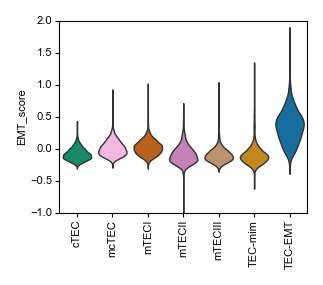

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.0, 1.5))
sc.pl.violin(adata_tec, keys = 'EMT_score', stripplot = False, groupby = 'taa_l3', size = 0.5, order = tec_l3, rotation = 90, show = False,ax = ax)
ax.set_ylim(-1, 2)
fig.savefig(f"{plot_path}/ThyAge_TEC-taa_l3-EMT_scores.pdf", dpi=300, bbox_inches="tight")
#plt.close()

<Axes: ylabel='EMT_score'>

(-1.0, 2.0)

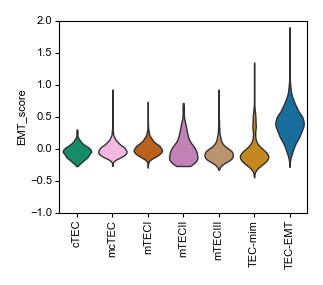

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.0, 1.5))
sc.pl.violin(adata_tec[adata_tec.obs['age_group'] == 'adult'],stripplot = False, keys = 'EMT_score', groupby = 'taa_l3', size = 0.5, order = tec_l3, rotation = 90, show = False,ax = ax)
ax.set_ylim(-1, 2)
fig.savefig(f"{plot_path}/ThyAge_TEC_adult-taa_l3-EMT_scores.pdf", dpi=300, bbox_inches="tight")
#plt.close()

<Axes: ylabel='EMT_score'>

(-1.0, 2.0)

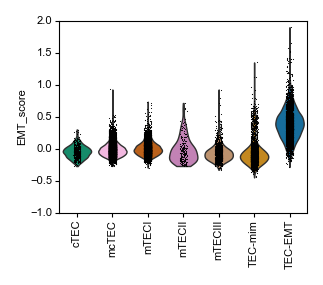

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.0, 1.5))
sc.pl.violin(adata_tec[adata_tec.obs['age_group'] == 'adult'],stripplot = True, keys = 'EMT_score', groupby = 'taa_l3', size = 0.5, order = tec_l3, rotation = 90, show = False,ax = ax)
ax.set_ylim(-1, 2)
fig.savefig(f"{plot_path}/ThyAge_TEC_adult-taa_l3-EMT_scores_strip.pdf", dpi=300, bbox_inches="tight")
#plt.close()

<Axes: ylabel='EMT_score'>

(-1.0, 2.0)

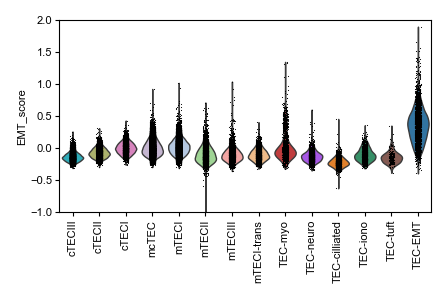

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3.0, 1.5))
sc.pl.violin(adata_tec, keys = 'EMT_score', groupby = 'taa_l5', size = 0.5, order = tec_l5, rotation = 90, show = False,ax = ax)
ax.set_ylim(-1, 2)
fig.savefig(f"{plot_path}/ThyAge_TEC-taa_l5-EMT_scores_strip.pdf", dpi=300, bbox_inches="tight")
#plt.close()

<Axes: ylabel='EMT_score'>

(-1.0, 2.0)

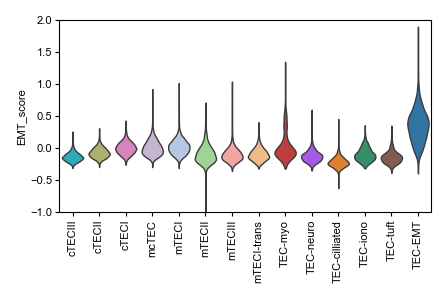

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3.0, 1.5))
sc.pl.violin(adata_tec, keys = 'EMT_score', stripplot = False, groupby = 'taa_l5', size = 0.5, order = tec_l5, rotation = 90, show = False,ax = ax)
ax.set_ylim(-1, 2)
fig.savefig(f"{plot_path}/ThyAge_TEC-taa_l5-EMT_scores.pdf", dpi=300, bbox_inches="tight")
#plt.close()

<Axes: ylabel='EMT_score'>

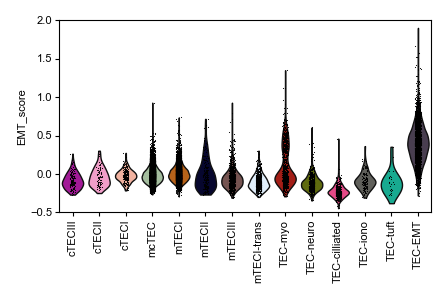

In [77]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3.0, 1.5))
sc.pl.violin(adata_tec[adata_tec.obs['age_group'] == 'adult'], keys = 'EMT_score', groupby = 'taa_l5', size = 0.5, order = tec_l5, rotation = 90, show = False,ax = ax)
fig.savefig(f"{plot_path}/ThyAge_TEC_adult-taa_l5-EMT_scores.pdf", dpi=300, bbox_inches="tight")
#plt.close()

In [ ]:
## aatec1_score

<Axes: ylabel='aatec1_score'>

(-1.0, 2.0)

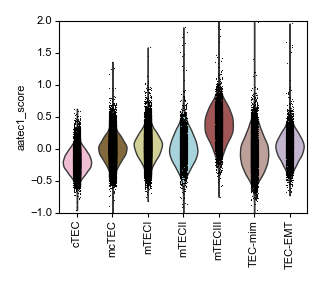

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.0, 1.5))
sc.pl.violin(adata_tec, keys = 'aatec1_score', groupby = 'taa_l3', size = 0.5, order = tec_l3, rotation = 90, show = False,ax = ax)
ax.set_ylim(-1, 2)
fig.savefig(f"{plot_path}/ThyAge_TEC-taa_l3-aatec1_score.pdf", dpi=300, bbox_inches="tight")
#plt.close()

In [78]:
## aatec2_score

<Axes: ylabel='aatec2_score'>

(-1.0, 2.0)

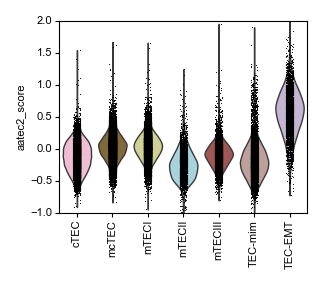

In [74]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(2.0, 1.5))
sc.pl.violin(adata_tec, keys = 'aatec2_score', groupby = 'taa_l3', size = 0.5, order = tec_l3, rotation = 90, show = False,ax = ax)
ax.set_ylim(-1, 2)
fig.savefig(f"{plot_path}/ThyAge_TEC-taa_l3-aatec2_score.pdf", dpi=300, bbox_inches="tight")
#plt.close()

## Plot TEC-EMT in the context of other stroma

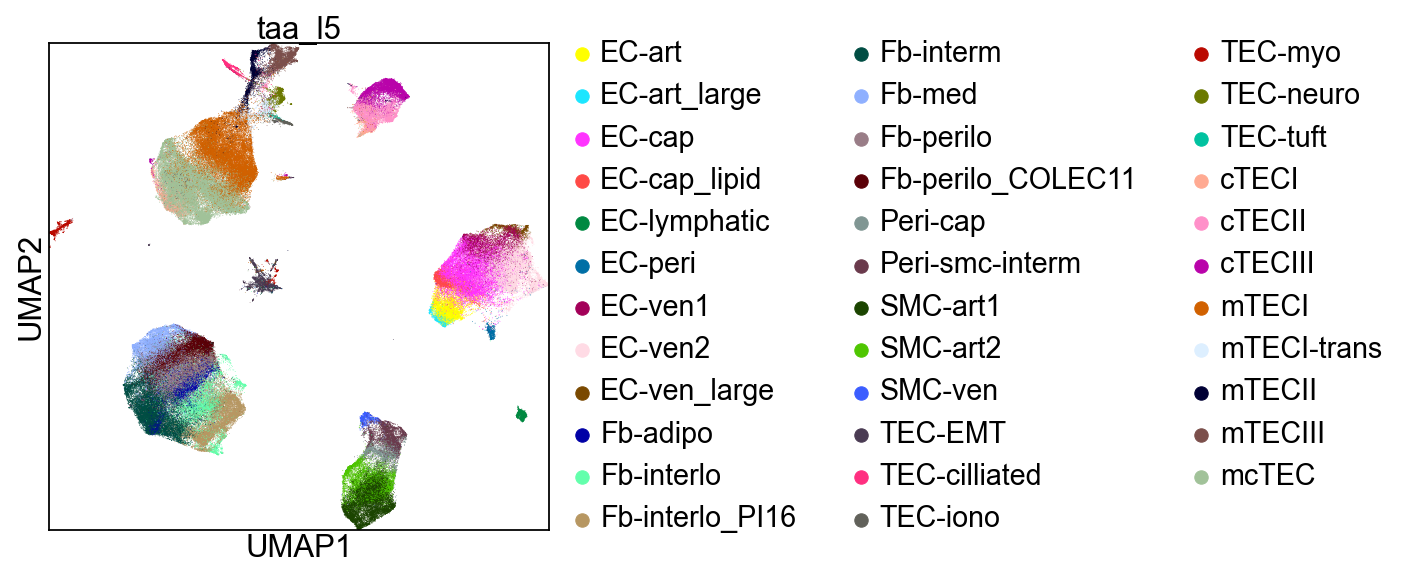

AnnData object with n_obs × n_vars = 236206 × 35530
    obs: 'barcode', 'sample', 'library', 'index', 'library_tcr_ab', 'library_tcr_gd', 'library_bcr', 'path_raw_gex', 'starsolo_version', 'path_cellbender_gex', 'path_cellranger_arc', 'donor', 'chemistry_simple', 'chemistry_detail', 'chemistry_orig', 'origin_institute', 'research_no', 'study', 'sort', 'sort_type', 'in_HTSA', 'public_data', 'type', 'cite', 'health_status', 'age_group', 'age_group2', 'age', 'age_num', 'age_unit', 'age_cont', 'sex', 'age_months', 'path_tcr_ab', 'path_tcr_gd', 'path_bcr', 'comment', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'scrublet_score', 'predicted_doublet', 'taa_l5', 'anno_status', 'qc_status', 'taa_l4', 'taa_l3', 'taa_l2', 'taa_l1', 'taa_l0', 'pri_anno', 'EMT_score'
    var: 'gene_id', 'gene_name'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'chemistry_simple_colors', 'donor_colors', 'hvg', 'neighbors', 'sex_colors', 'umap', 'log1p', 'taa_l5_colors'
    obsm: 'X_scVI', 'X_u

In [23]:
regen_embed(adata_stroma,anno2show='taa_l5')

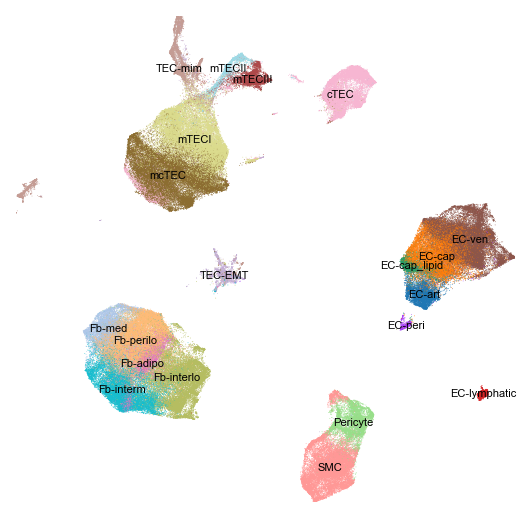

In [39]:
sc.pl.umap(adata_stroma, color = 'taa_l3', frameon = False, legend_loc = 'on data', legend_fontsize = 5, title = '', return_fig = True).savefig(f'{plot_path}/TEC_EMT_in_stroma_UMAP.pdf', bbox_inches = 'tight')

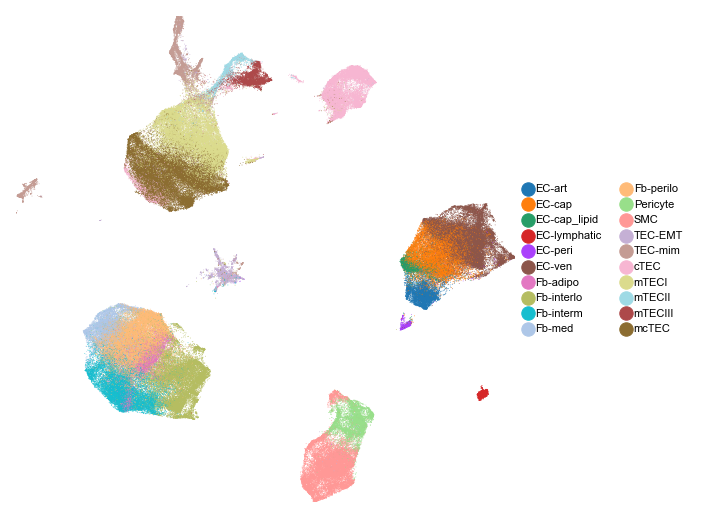

In [40]:
sc.pl.umap(adata_stroma, color = 'taa_l3', frameon = False, legend_fontsize = 5, title = '', return_fig = True).savefig(f'{plot_path}/TEC_EMT_in_stroma_UMAP.png', bbox_inches = 'tight')

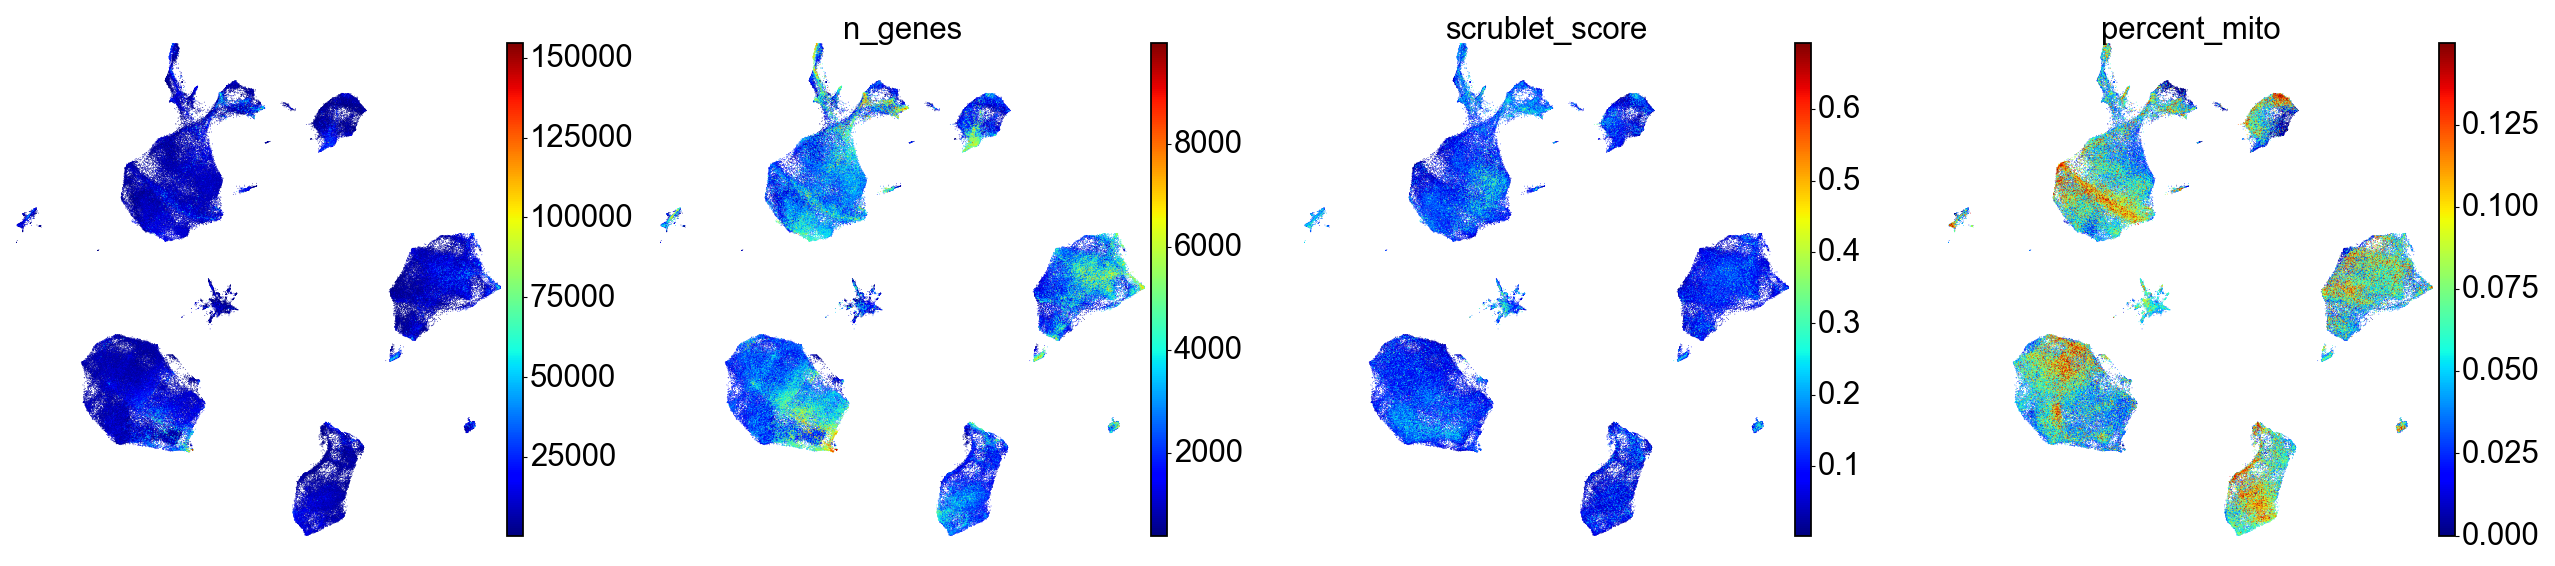

In [42]:
sc.pl.umap(adata_stroma, color = ['n_counts', 'n_genes', 'scrublet_score', 'percent_mito'], frameon = False, 
           legend_fontsize = 5, title = '', return_fig = True, cmap = 'jet').savefig(f'{plot_path}/TEC_EMT_qc_UMAP.png', bbox_inches = 'tight')

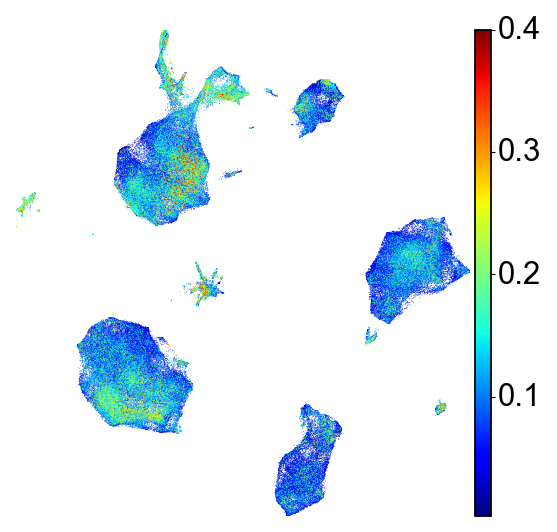

In [43]:
sc.pl.umap(adata_stroma, color = 'scrublet_score', frameon = False, 
           legend_fontsize = 5, title = '', return_fig = True, cmap = 'jet', vmax = 0.4).savefig(f'{plot_path}/TEC_EMT_qc_scrublet_UMAP.png', bbox_inches = 'tight')

In [44]:
emt_mrkrs = {'epi': ['KRT5', 'KRT15', 'KRT14'], 
             'mesenchymal': ['PDGFRA', 'ACTA2', 'MYH11',  'VIM'], 
             'EMT TFs': ['TWIST1', 'ZEB1', 'ZEB2']}

In [60]:
tec_mrkrs = {'pan-cTEC':['CCL25', 'HLA-DRA', 'LY75', 'PSMB11', 'KRT8', 'KRT18'],
        'cTEC\nsubtypes':['TBATA', 'TP53AIP1', 'DLL4'],
        'mcTEC':['DLK2','IGFBP6', 'IGFBP5', 'CCN2', 'CCL2'],
        'stem\nmarkers': ['KRT15', 'KRT18', 'KRT19', 'BCAM', 'ITGA6', 'MKI67'],
        'pan-mTEC': ['EPCAM', 'KRT5', 'KRT14'],
        'mTECI': ['CCL19','CCL21', 'ASCL1'],
        'EMT': ['VIM', 'TWIST1', 'ZEB1'],
        'mTECII': ['AIRE', 'FEZF2','CRIP1', 'CLDN3', 'CLDN4'], 
        'mTECIII':['SLPI', 'IVL', 'KRT10','CDKN2A'],
        'pan-neuro TEC': ['BEX1', 'NEUROD1'],
        'neuroTEC': ['NEUROG1', 'NEUROD4'], 
        'cilliated TEC': ['PCP4', 'FOXJ1'], 
        'myoTEC':['CHRNA1', 'MYOG', 'TTN'],
        'ionocytes':['FOXI1', 'CFTR'],
        'tuft cells':['POU2F3','PLCB2', 'TRPM5', 'CHAT']}

In [45]:
from plotting.utils import plot_grouped_boxplot,thyAgeing_colors

In [46]:
stroma_lev3 = get_ct_levels('taa_l3', taa_l1=['TEC', 'Fb', 'EC', 'Mural'])

Latest file: thyAgeing_full_curatedAnno_v9_2025-03-03_levels.xlsx


In [63]:
stroma_lev2 = get_ct_levels('taa_l2', taa_l1=['TEC', 'Fb', 'EC', 'Mural'])

Latest file: thyAgeing_full_curatedAnno_v9_2025-03-03_levels.xlsx


In [64]:
stroma_lev2

['cTEC',
 'mcTEC',
 'mTEC',
 'TEC-EMT',
 'Fb',
 'EC-blood',
 'EC-lymphatic',
 'SMC',
 'Pericyte']

In [56]:
stroma_lev4 = get_ct_levels('taa_l4', taa_l1=['TEC', 'Fb', 'EC', 'Mural'])

Latest file: thyAgeing_full_curatedAnno_v9_2025-03-03_levels.xlsx


In [ ]:
emt_mrkrs

In [52]:
plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')

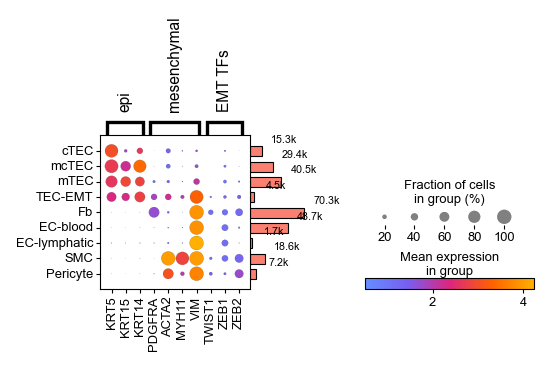

In [68]:
sc.pl.dotplot(adata_stroma, 
            categories_order=stroma_lev2,
            groupby = 'taa_l2',
            var_names=emt_mrkrs,
            figsize = (3.5,1.2),
            mean_only_expressed=True, swap_axes=False, return_fig=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_EMT_Markers_stroma_taa_l2_dotplot.pdf') 

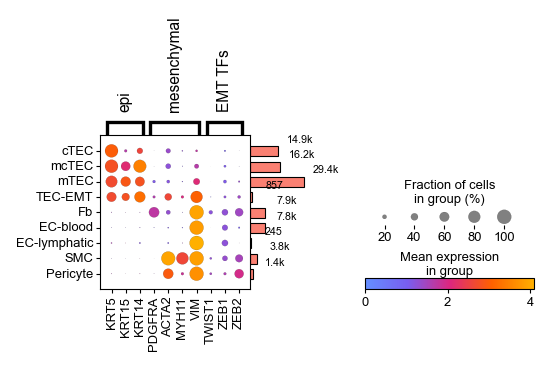

In [69]:
sc.pl.dotplot(adata_stroma[adata_stroma.obs['age_group'].isin(['infant', 'paed'])], 
            categories_order=stroma_lev2,
            groupby = 'taa_l2',
            var_names=emt_mrkrs,
            figsize = (3.5,1.2),
            mean_only_expressed=True, swap_axes=False, return_fig=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_EMT_Markers_stroma_taa_l2_dotplot_epaed.pdf') 

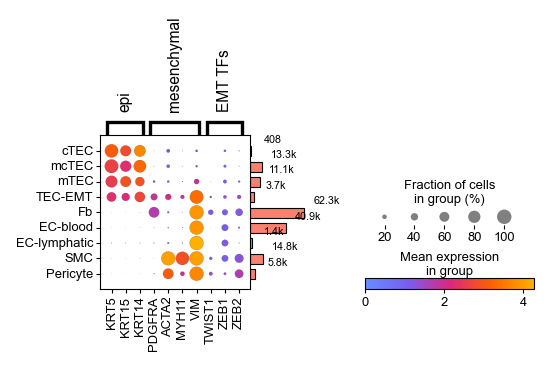

In [70]:
sc.pl.dotplot(adata_stroma[~adata_stroma.obs['age_group'].isin(['infant', 'paed'])], 
            categories_order=stroma_lev2,
            groupby = 'taa_l2',
            var_names=emt_mrkrs,
            figsize = (3.5,1.2),
            mean_only_expressed=True, swap_axes=False, return_fig=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_EMT_Markers_stroma_taa_l2_dotplot_adult.pdf') 

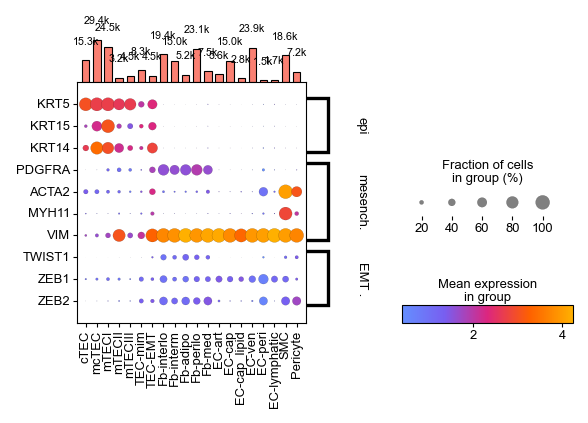

In [ ]:
sc.pl.dotplot(adata_stroma, 
            categories_order=stroma_lev3,
            groupby = 'taa_l3',
            var_names=emt_mrkrs,
            figsize = (4,2),
            mean_only_expressed=True, swap_axes=True, return_fig=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_EMT_Markers_stroma_taa_l3_dotplot.pdf') 

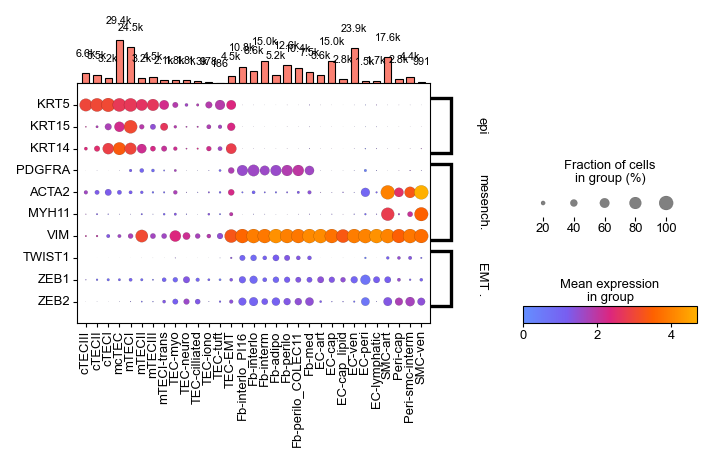

In [62]:
sc.pl.dotplot(adata_stroma, 
            categories_order=stroma_lev4,
            groupby = 'taa_l4',
            var_names=emt_mrkrs,
            figsize = (5,2),
            mean_only_expressed=True, swap_axes=True, return_fig=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_EMT_Markers_stroma_taa_l4_dotplot.pdf') 

In [63]:
plt.style.use('/nfs/team205/vk8/projects/thymus_ageing_atlas/General_analysis/scripts/plotting/thyAgeing.mplstyle')


Width exceeds the maximum width of 183 mm


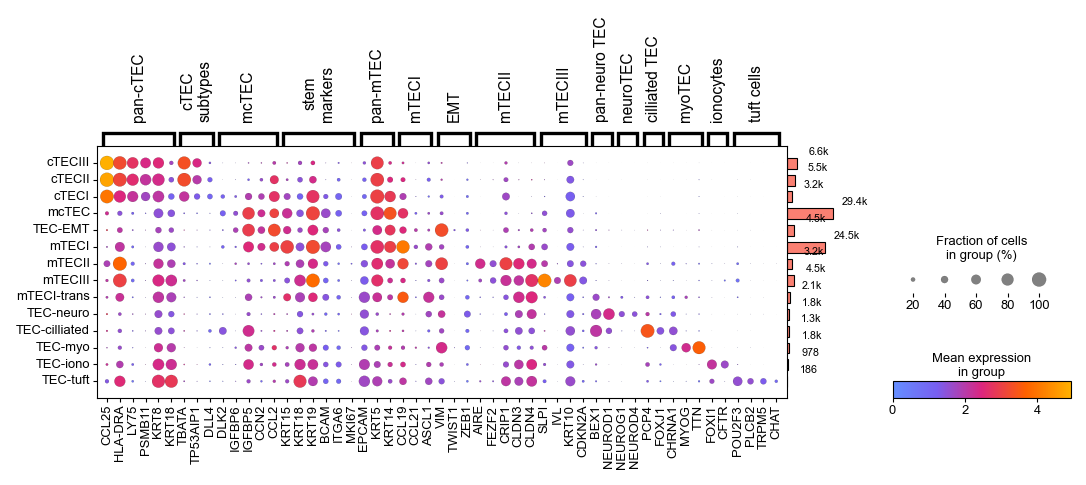

In [64]:
sc.pl.DotPlot(adata, 
            categories_order=tec_fine_ctypes,
            groupby = 'taa_l5',
            var_names=tec_mrkrs,
            figsize = calc_figsize(width = 200, height = 50),
            mean_only_expressed=True,
            cmap = sns.blend_palette([thyAgeing_colors['blue'], thyAgeing_colors['purple'], thyAgeing_colors['magenta'], thyAgeing_colors['orange'], thyAgeing_colors['yellow']], as_cmap=True,), #'magma',
            ).style(smallest_dot=0, largest_dot = 40, dot_edge_lw=0.05).add_totals(size = 0.5).savefig(f'{plot_path}/thyAgeing_TEC_taa-l5_TEC_Markers_dotplot_v2.pdf') 